# Heatmap (countour plot) of model predictions

## Load packages

In [2]:
import itertools
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib as mpl
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score
import hyperopt
#import model_helper
import ml_helper as ml_help
import tune
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

## Load data

In [3]:
#SMOTE = False
K_NEIGHBOURS = 5
N_SPLITS = 10
TUNE = True
directory = '../../Data/tidy_data/'

In [4]:
FILENAME = 'ml_during_hypo_5.csv'
df = pd.read_csv(directory + FILENAME)
target_columns = 'y_hypo'
df.dropna(inplace=True, subset=['start_glc','duration'])

FILENAME = 'ml_during_hyper.csv'
df = pd.read_csv(directory + FILENAME)
target_columns = 'y_hyper'
df.dropna(inplace=True, subset=['start_glc','duration'])

In [5]:
X = df[['start_glc','duration']]
y = df[target_columns]

In [5]:
y.value_counts()

False    758
True     220
Name: y_hypo, dtype: int64

### Restrict data to two features before model fitting

## Split into training and test sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [8]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

## Standardise data

In [14]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [8]:
X_train_std, X_test_std = standardise_data(X_train, X_test)
#X_train_std, X_test_std = standardise_data(X, X)

In [10]:
X = StandardScaler().fit_transform(X)

## Fit model and check accuracy

In [9]:
# Define hyperparameter space
params = {'penalty' : hyperopt.hp.choice('penalty', ['l2', 'l1']), # , 'l1'
          'C' : hyperopt.hp.loguniform('C', -4, 4), #20
          'solver' : hyperopt.hp.choice('solver', ['lbfgs', 'liblinear']), #'max_iter': [1000] 'liblinear',
         }

In [10]:
model = LogisticRegression
best_params = tune.hyperopt_tune(model, params, None, X_train_std, y_train,
                                 'roc_auc', 60)
tuned_model = model(**best_params)
tuned_model.fit(X_train_std,y_train)

100%|██████████| 60/60 [00:02<00:00, 21.18trial/s, best loss: -0.836539048455203] 


LogisticRegression(C=0.06662641355374649, solver='liblinear')

In [11]:
tuned_model.coef_

array([[-1.32253235,  0.38839966]])

In [12]:
# Predict training and test set labels
y_pred_train = tuned_model.predict(X_train_std)
y_pred_test = tuned_model.predict(X_test_std)

In [13]:
y_probs_test = tuned_model.predict_proba(X_test_std)

In [14]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print ('Accuracy of predicting training data =', accuracy_train)
print ('Accuracy of predicting test data =', accuracy_test)

Accuracy of predicting training data = 0.8147727272727273
Accuracy of predicting test data = 0.8979591836734694


## Calibration

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Convert data to NumPy arrays (required for stratified k-fold)
X_np = X.values
y_np = y.values

# Set up k-fold splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, 
                      random_state=42)
skf.get_n_splits(X_np, y_np)

# Define bins
number_of_bins = 10

# Set up results DataFrames (to get results from each run)
results_model_probability = []
results_fraction_positive = []

# Loop through the k-fold splits
loop_counter = 0
for train_index, test_index in skf.split(X_np, y_np):    
        
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Set up and fit model
    model = LogisticRegression()
    model.fit(X_train,y_train)
    
    # Get test set proabilities
    y_calibrate_probabilities = model.predict_proba(X_test)[:,1]
    
    # Get calibration curve (use quantile to make sure all bins exist)
    fraction_pos, model_prob = calibration_curve(
        y_test, y_calibrate_probabilities, 
        n_bins=number_of_bins,
        strategy='quantile')    

    # record run results
    results_model_probability.append(model_prob)
    results_fraction_positive.append(fraction_pos)
    
    # Increment loop counter
    loop_counter += 1
    
# Convert results to DataFrame
results_model_probability = pd.DataFrame(results_model_probability)
results_fraction_positive = pd.DataFrame(results_fraction_positive)

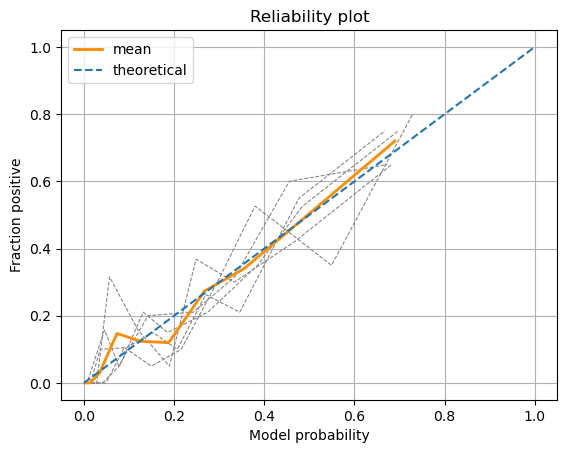

In [7]:
%matplotlib inline

# Add individual k-fold runs
for run in range(number_of_splits):
    plt.plot(results_model_probability.loc[run],
             results_fraction_positive.loc[run],
             linestyle='--',
             linewidth=0.75,
             color='0.5')
    
# Add mean
plt.plot(results_model_probability.mean(axis=0),
         results_fraction_positive.mean(axis=0),
         linestyle='-',
         linewidth=2,
         color='darkorange',
         label='mean')

# Add diagonal
plt.plot([0,1],[0,1],
         linestyle='--',
         label='theoretical')

plt.xlabel('Model probability')
plt.ylabel('Fraction positive')

plt.title('Reliability plot')

plt.grid()
plt.legend()
plt.show()

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Convert data to NumPy arrays (required for stratified k-fold)
X_np = X.values
y_np = y.values

# Set up k-fold splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits, shuffle=True, 
                      random_state=42)
skf.get_n_splits(X_np, y_np)

# Define bins
number_of_bins = 10

# Set up results DataFrames (to get results from each run)
results_model_probability = []
results_fraction_positive = []

# Loop through the k-fold splits
loop_counter = 0
for train_index, test_index in skf.split(X_np, y_np):    
        
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
    
    # Set up and fit model
    model = LogisticRegression()
    model.fit(X_train,y_train)
    
    # Get test set proabilities
    y_calibrate_probabilities = model.predict_proba(X_test)[:,1]
    
    # Get calibration curve (use quantile to make sure all bins exist)
    fraction_pos, model_prob = calibration_curve(
        y_test, y_calibrate_probabilities, 
        n_bins=number_of_bins,
        strategy='quantile')    

    # record run results
    results_model_probability.append(model_prob)
    results_fraction_positive.append(fraction_pos)
    
    # Increment loop counter
    loop_counter += 1
    
# Convert results to DataFrame
results_model_probability = pd.DataFrame(results_model_probability)
results_fraction_positive = pd.DataFrame(results_fraction_positive)

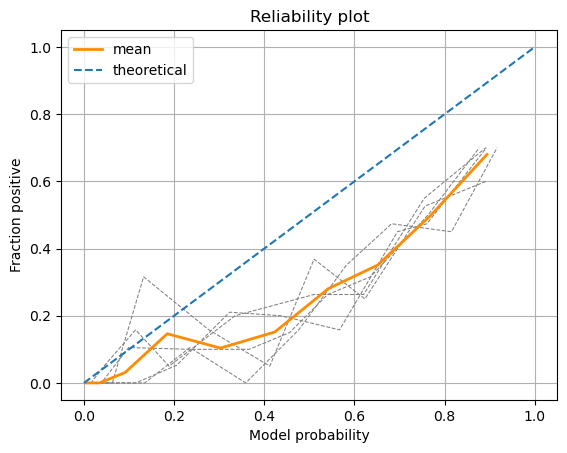

In [9]:
%matplotlib inline

# Add individual k-fold runs
for run in range(number_of_splits):
    plt.plot(results_model_probability.loc[run],
             results_fraction_positive.loc[run],
             linestyle='--',
             linewidth=0.75,
             color='0.5')
    
# Add mean
plt.plot(results_model_probability.mean(axis=0),
         results_fraction_positive.mean(axis=0),
         linestyle='-',
         linewidth=2,
         color='darkorange',
         label='mean')

# Add diagonal
plt.plot([0,1],[0,1],
         linestyle='--',
         label='theoretical')

plt.xlabel('Model probability')
plt.ylabel('Fraction positive')

plt.title('Reliability plot')

plt.grid()
plt.legend()
plt.show()

## Check limits of data

In [133]:
X.min()

start_glc     2.2
duration     10.0
dtype: float64

<AxesSubplot:>

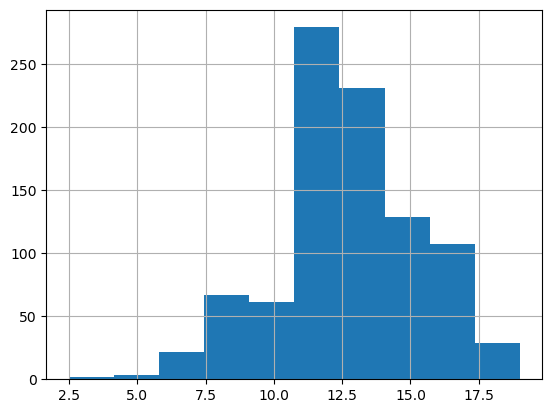

In [31]:
df.intensity.hist()

In [134]:
X.max()

start_glc     22.6
duration     120.0
dtype: float64

## Create a grid of evenly spaced feature values

In [10]:
# After doing the contour plot on full extent values, I reduced age to ages that made a difference in the plot
x1 = np.linspace(4,16,20)
#mg/dl
#x1 = np.linspace(70,260,20)

x2 = np.linspace(10,120,20)

In [11]:
start_glc = []
duration = []
for i in x1:
    for j in x2:
        start_glc.append(i)
        duration.append(j)

Put in DataFrame.

In [12]:
test_df = pd.DataFrame()
test_df['Starting glucose'] = start_glc
#mg/dl
#test_df['Starting glucose'] = test_df['Starting glucose']
test_df['Duration'] = duration

## Standardise new test set and get model predictions

In [13]:
X_train_std, X_test_std = standardise_data(X, test_df)

NameError: name 'standardise_data' is not defined

In [21]:
y = tuned_model.predict_proba(X_test_std)
# Get probability of survival
y = y[:, 1].flatten()

In [22]:
test_df['y']= y

In [36]:
test_df

,Starting glucose,Duration,y
0,4.0,10.000000,0.451788
1,4.0,15.789474,0.474910
2,4.0,21.578947,0.498141
3,4.0,27.368421,0.521379
4,4.0,33.157895,0.544525
...,...,...,...
395,16.0,96.842105,0.063014
396,16.0,102.631579,0.068733
397,16.0,108.421053,0.074931
398,16.0,114.210526,0.081638


## Reformat data and results for contour plot

In [24]:
x1_grid, x2_grid = np.meshgrid(x1, x2)

In [25]:
y_grid_hypo = np.reshape(y, x1_grid.shape)

## Plot

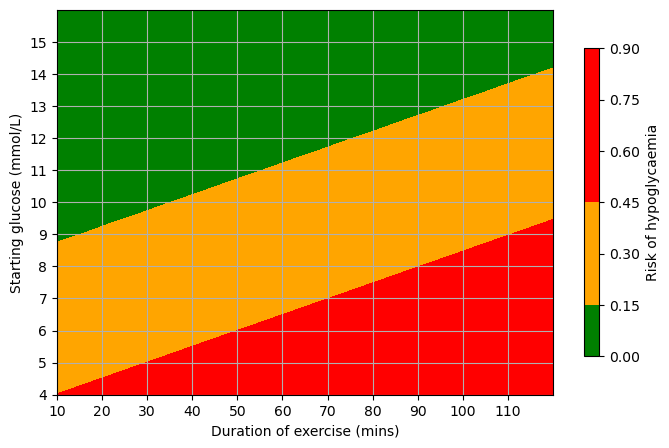

In [43]:
fig_hypo = plt.figure(figsize=(8,5))
ax = fig_hypo.add_subplot(111)
#segments = ["green","orange","red"]
segments = [(0.0, 'green'),  (0.2, 'green'),(0.2, 'orange'), (0.5, 'orange'),(0.5, 'red'), (1.0, 'red')]
cs = ax.contourf(x2_grid, x1_grid, y_grid_hypo.T, 
                 cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", segments),
                vmin = 0, vmax =1)

ax.set_ylabel('Starting glucose (mmol/L)')
ax.set_xlabel('Duration of exercise (mins)')
plt.xticks(np.arange(10, 120,10))
plt.yticks(np.arange(4, 16,1))
# Add a colorbar
cbar = fig_hypo.colorbar(cs, shrink=0.8, extend='neither')
cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()
#plt.gca().invert_yaxis()
plt.show()
#fig_hypo.savefig('hypoglycemia.svg')

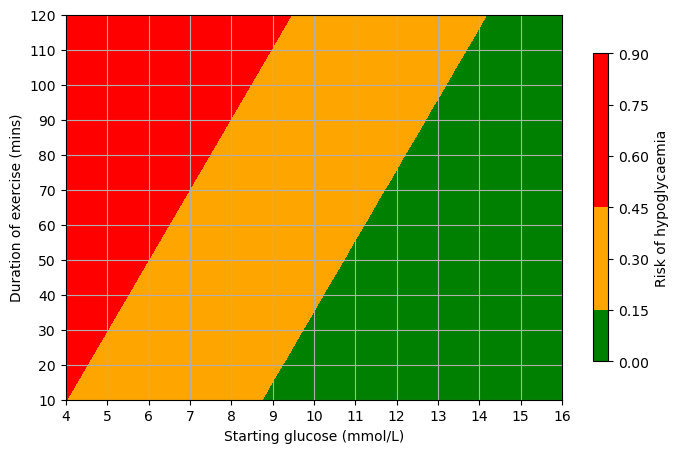

In [62]:
fig_hypo = plt.figure(figsize=(8,5))
ax = fig_hypo.add_subplot(111)
#segments = ["green","orange","red"]
segments = [(0.0, 'green'),  (0.15, 'green'),(0.15, 'orange'), (0.5, 'orange'),(0.5, 'red'), (1.0, 'red')]
cs = ax.contourf(x1_grid, x2_grid, y_grid_hypo.T, 
                 cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", segments),
                vmin = 0, vmax =1)

ax.set_xlabel('Starting glucose (mmol/L)')
ax.set_ylabel('Duration of exercise (mins)')
plt.yticks(np.arange(10, 130,10))
plt.xticks(np.arange(4, 17,1))
# Add a colorbar
cbar = fig_hypo.colorbar(cs, shrink=0.8, extend='neither')
cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()
#plt.gca().invert_yaxis()
plt.show()
#fig_hypo.savefig('hypoglycemia.svg')

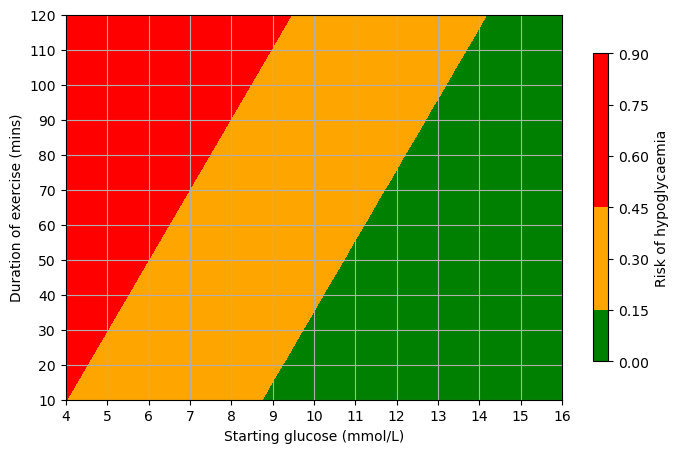

In [58]:
fig_hypo = plt.figure(figsize=(8,5))
ax = fig_hypo.add_subplot(111)
#segments = ["green","orange","red"]
segments = [(0.0, 'green'),  (0.2, 'green'),(0.2, 'orange'), (0.5, 'orange'),(0.5, 'red'), (1.0, 'red')]
cs = ax.contourf(x1_grid, x2_grid, y_grid_hypo.T, 
                 cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", segments),
                vmin = 0, vmax =1)

ax.set_xlabel('Starting glucose (mmol/L)')
ax.set_ylabel('Duration of exercise (mins)')
plt.yticks(np.arange(10, 130,10))
plt.xticks(np.arange(4, 17,1))
# Add a colorbar
cbar = fig_hypo.colorbar(cs, shrink=0.8, extend='neither')
cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()
#plt.gca().invert_yaxis()
plt.show()
#fig_hypo.savefig('hypoglycemia.svg')

In [59]:
test_df[(test_df['y']>0.13 )& (test_df['y']<0.17)]

,Starting glucose,Duration,y
140,8.421053,10.000000,0.163742
160,9.052632,10.000000,0.137530
161,9.052632,15.789474,0.148939
162,9.052632,21.578947,0.161117
182,9.684211,21.578947,0.135257
183,9.684211,27.368421,0.146509
184,9.684211,33.157895,0.158525
204,10.315789,33.157895,0.133015
205,10.315789,38.947368,0.144111
206,10.315789,44.736842,0.155967


In [49]:
test_df[(test_df['Starting glucose']==9.0) & (test_df['Duration']==15.0)]

,Starting glucose,Duration,y


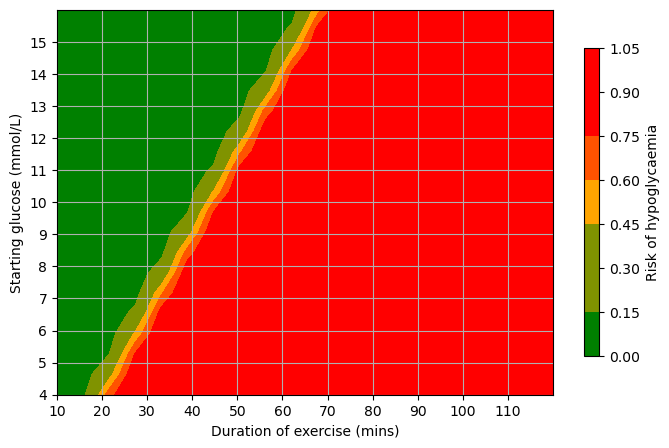

In [31]:

fig_hypo = plt.figure(figsize=(8,5))
ax = fig_hypo.add_subplot(111)
cs = ax.contourf(x2_grid, x1_grid, y_grid_hypo.T, 
                 cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","orange","red"], N=3),
                vmin = 0, vmax =1)

ax.set_ylabel('Starting glucose (mmol/L)')
ax.set_xlabel('Duration of exercise (mins)')
plt.xticks(np.arange(10, 120,10))
plt.yticks(np.arange(4, 16,1))
# Add a colorbar
cbar = fig_hypo.colorbar(cs, shrink=0.8, extend='neither')
cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()
#plt.gca().invert_yaxis()
plt.show()
#fig_hypo.savefig('hypoglycemia.svg')

In [31]:
y.max()

0.9917309686829713

In [ ]:
cmap='jet'

In [1]:
## Create figure
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cs = ax.contourf(x2_grid, x1_grid, y_grid_hypo.T, cmap='jet', levels=100)

ax.set_ylabel('Starting glucose (mmol/L)')
ax.set_xlabel('Duration of exercise (mins)')
#ax.set_title(title)
# Add a colorbar
cbar = plt.colorbar(cs, shrink=0.8, norm=mpl.colors.Normalize(vmin=0, vmax=1))
cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()

NameError: name 'plt' is not defined

In [27]:
# Functions for determining the British and American glucose axis for the plots
def mmol2mg(x):
    return x / 0.0555
def mg2mmol(x):
    return x * 0.0555

NameError: name 'mmol2mg' is not defined

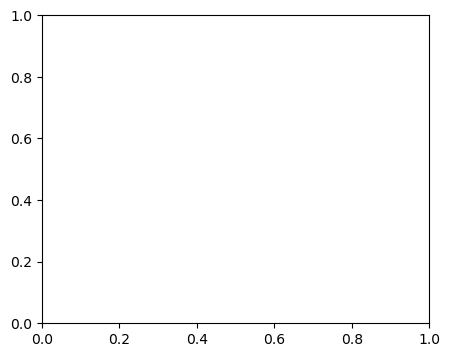

In [53]:
fig_hypo = plt.figure(figsize=(5,4))
ax = fig_hypo.add_subplot(111)
secax = ax.secondary_yaxis('right', functions=(mmol2mg, mg2mmol))
cs = ax.contourf(x2_grid, x1_grid, y_grid_hypo.T, 
                 cmap='viridis_r', vmin = 0, vmax =1, levels=10)

ax.set_ylabel('Starting glucose (mmol/L)')
secax.set_ylabel('Starting glucose (mg/dL)')

ax.set_xlabel('Duration of exercise (mins)')

plt.xticks(np.arange(20, 110,10))
plt.yticks(np.arange(4, 17,1))
# Add a colorbar
cbar = fig_hypo.colorbar(cs, shrink=0.8, extend='neither', norm=mpl.colors.Normalize(vmin=0, vmax=1))
cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()
#plt.gca().invert_yaxis()
#plt.show()
fig.tight_layout()
#fig_hypo.savefig('contour_plots/hypo_viridis_10_lvls.svg')

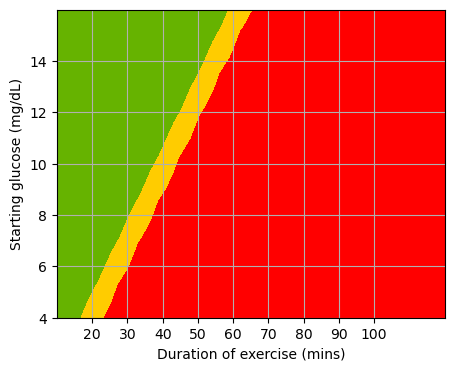

In [54]:
fig_hypo = plt.figure(figsize=(5,4))
ax = fig_hypo.add_subplot(111)
cs = ax.contourf(x2_grid, (x1_grid), y_grid_hypo.T, 
                 cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"]),
                levels=2, vmin = 0, vmax =1)

ax.set_ylabel('Starting glucose (mg/dL)')
ax.set_xlabel('Duration of exercise (mins)')
plt.xticks(np.arange(20, 110,10))
plt.yticks(np.arange(4,16, 2))
# Add a colorbar
#cbar = fig_hypo.colorbar(cs, shrink=0.8, extend='neither')
#cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()
#plt.gca().invert_yaxis()
#plt.show()
#fig_hypo.savefig('contour_plots/hypo_traffic_light_4_bins_mg_dl.svg')

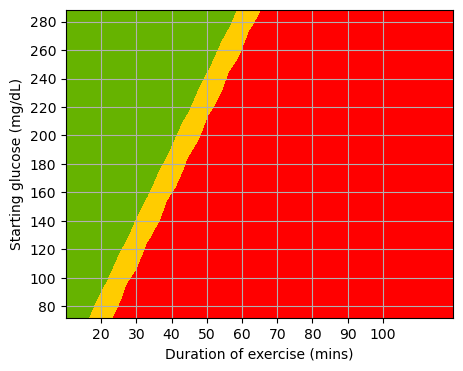

In [51]:
fig_hypo = plt.figure(figsize=(5,4))
ax = fig_hypo.add_subplot(111)
cs = ax.contourf(x2_grid, (x1_grid/ 0.0555), y_grid_hypo.T, 
                 cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"]),
                levels=2, vmin = 0, vmax =1)

ax.set_ylabel('Starting glucose (mg/dL)')
ax.set_xlabel('Duration of exercise (mins)')
plt.xticks(np.arange(20, 110,10))
plt.yticks(np.arange(80,300, 20))
# Add a colorbar
#cbar = fig_hypo.colorbar(cs, shrink=0.8, extend='neither')
#cbar.ax.set_ylabel('Risk of hypoglycaemia')
ax.grid()
#plt.gca().invert_yaxis()
#plt.show()
#fig_hypo.savefig('contour_plots/hypo_traffic_light_4_bins_mg_dl.svg')

NameError: name 'fig_hyper' is not defined

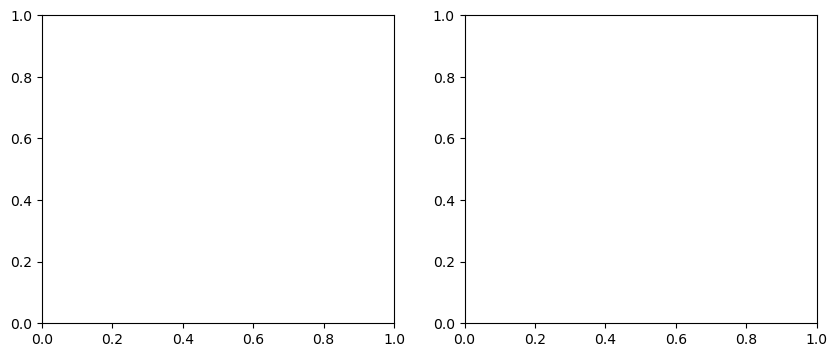

In [52]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
ax[0] = fig_hyper.add_subplot(111)
cs = ax[0].contourf(x2_grid, x1_grid, y_grid_hyper.T, cmap='jet', levels=100)

ax[0].set_ylabel('Starting glucose (mmol/L)')
ax[0].set_xlabel('Duration of exercise (mins)')

# Add a colorbar
cbar = fig_hyper.colorbar(cs, shrink=0.8)
cbar.ax[0].set_ylabel('Risk of hyperglycaemia')
ax[0].grid()
#plt.gca().invert_yaxis()

#plt.show()
#fig_hyper.savefig('hyperglycemia.svg')

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0] = fig_hypo
ax[1] = fig_hyper

In [ ]:
y_hypo = y_grid

y_hyper = y_grid

In [ ]:
ax = fig_hypo.add_subplot(111)


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
cs = ax[0].contourf(x2_grid, x1_grid, y_grid_hypo.T, cmap='jet', levels=100)

ax[0].set_ylabel('Starting glucose (mmol/L)')
ax[0].set_xlabel('Duration of exercise (mins)')

cs = ax[1].contourf(x2_grid, x1_grid, y_grid_hyper.T, cmap='jet', levels=100)

ax[1].set_ylabel('Starting glucose (mmol/L)')
ax[1].set_xlabel('Duration of exercise (mins)')

ax[0].set_title('a) Prediction of low glucose event')
ax[1].set_title('b) Prediction of high glucose event')

# Add a colorbar
cbar = fig.colorbar(cs, shrink=0.8)
#cbar = ax[1].colorbar(cs, shrink=0.8)

cbar.ax.set_ylabel('Risk of event')
#cbar.ax[1].set_ylabel('Risk of high event')

ax[0].grid()
ax[1].grid()
fig.tight_layout()
fig.savefig('fig_for_easd.jpg')

a) prediction of glucose less than 7

In [ ]:
tuned_model.predict(np.array([[5],[40]]))